## 抓取高鐵驗證碼

In [ ]:
! mkdir data

In [ ]:
import requests
from bs4 import BeautifulSoup

headers = {
  'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'  
}

def getCaptcha(i):
    rs = requests.session()
    res = rs.get('https://irs.thsrc.com.tw/IMINT/', headers = headers)
    soup = BeautifulSoup(res.text, 'lxml')
    domain = 'https://irs.thsrc.com.tw'
    imgsrc = soup.select_one('img#BookingS1Form_homeCaptcha_passCode').get('src')
    imgurl = domain + imgsrc
    res2 = rs.get(imgurl, headers = headers)
    with open('data/{}.jpg'.format(i), 'wb') as f:
        f.write(res2.content)

In [ ]:
#getCaptcha(1)

## 載入驗證碼圖片

In [ ]:
! wget https://raw.githubusercontent.com/ywchiu/fubondl/main/data/captcha_jpg.zip

--2021-01-15 06:23:05--  https://raw.githubusercontent.com/ywchiu/fubondl/main/data/captcha_jpg.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3818150 (3.6M) [application/zip]
Saving to: ‘captcha_jpg.zip’

captcha_jpg.zip     100%[===================>]   3.64M  --.-KB/s    in 0.1s    

2021-01-15 06:23:06 (34.0 MB/s) - ‘captcha_jpg.zip’ saved [3818150/3818150]



In [ ]:
! unzip captcha_jpg.zip > 1.log

In [ ]:
! ls data/ | wc -l

999


In [ ]:
from PIL import Image
img = Image.open('data/1.jpg')
img.size

(135, 47)

In [ ]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/fubondl/main/data/output_captua.csv', index_col = 0)

In [ ]:
df.dropna(inplace=True)
df['file'] = df['file'].map(lambda e: 'data/{}.jpg'.format(int(e)) )

In [ ]:
df.head()

,captcua,file
0.0,4ay2,data/1.jpg
2.0,qmqh,data/2.jpg
4.0,kc3c,data/3.jpg
6.0,1549,data/4.jpg
8.0,5rqz,data/5.jpg


In [ ]:
len(df)

998

## 建立 CNN 模型

In [ ]:
characters = '0123456789abcdefghijklmnopqrstuvwxyz'
# Captcha生成圖像的寬高、用幾個字母來組成字串及會用到的字母數
width, height, n_len, n_class = 135, 47, 4, 36

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense

input_tensor = Input((height, width, 3))

x = input_tensor

#  模仿 VGG  架構模型
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x) 

x = Conv2D(256, (3, 3), activation='relu')(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x) 

x = Flatten()(x)
x = Dropout(0.25)(x)

x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 47, 135, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 45, 133, 64)  1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 43, 131, 64)  36928       conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 21, 65, 64)   0           conv2d_13[0][0]                  
____________________________________________________________________________________________

## 訓練模型

In [ ]:
import os 
os.mkdir('trainset')

In [ ]:
import numpy as np
X = np.zeros((len(df), height, width, 3), dtype=np.float32)
y = [np.zeros((len(df), n_class), dtype=np.uint8) for i in range(n_len)]

In [ ]:
X.shape

(998, 47, 135, 3)

In [ ]:
len(y)
y[0].shape

(998, 36)

In [ ]:
df.reset_index(drop = 'index', inplace=True)

In [ ]:
for i in df.index:
    random_str = df.loc[i,'captcua']
    fname = df.loc[i,'file']
    f1 = Image.open(fname)
    f1 = f1.resize((width, height))
    f = np.array(f1)
    #print(f.shape)
    #f.resize(height,width)
    #print(f)
    X[i] = f * 1.0 / 255.0
    for j, ch in enumerate(random_str):
        y[j][i, :] = 0
        y[j][i, characters.find(ch)] = 1

In [ ]:
X[0].shape

(47, 135, 3)

In [ ]:
y[0][0]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
import random
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.float32)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    while True:
        
        for i in range(batch_size):
            rand_index = random.choice(df.index)
            random_str = df.loc[rand_index,'captcua']
            fname = df.loc[rand_index,'file']
            f1 = Image.open(fname)
            f1 = f1.resize((width, height))
            f = np.array(f1)
            X[i] = f / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

In [ ]:
for x,y in gen(batch_size = 32):
  print(x.shape)
  print(len(y))
  break

(32, 47, 135, 3)
4


In [ ]:
from tensorflow.keras import callbacks
cbks = [callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)]

history = model.fit_generator(gen(batch_size=32),      # 每次生成器會產生32筆小批量的資料
                    epochs=20,                          # 總共跑20個訓練循環
                    steps_per_epoch=1000,     # 每個epoch 產生1000 組batch
                    #callbacks=cbks,          # 保存最好的模型到檔案
                    validation_data=gen(),   # 驗證資料也是用生成器來產生
                    validation_steps=40      # 用40組資料來驗證
                   )

## 測試模型

In [ ]:
img = Image.open('data/567.jpg')

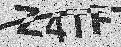

In [ ]:
img

In [ ]:
img.size

(121, 47)

In [ ]:
width

135

In [ ]:
X1 = np.array(img.resize((width, height)))
X1 = X1 * 1.0 / 255.0

In [ ]:
X1.shape

(47, 135, 3)

In [ ]:
X1 = X1.reshape((1, height, width, 3))

In [ ]:
X1.shape

(1, 47, 135, 3)

In [ ]:
[np.argmax(e) for e in model.predict(X1)]

[35, 4, 29, 15]

In [ ]:
characters = '0123456789abcdefghijklmnopqrstuvwxyz'
[characters[np.argmax(e)] for e in model.predict(X1)]

['z', '4', 't', 'f']

## Mask RCNN

In [1]:
!  wget https://raw.githubusercontent.com/ywchiu/fubondl/main/data/car_archive.zip 

--2021-01-15 08:45:28--  https://raw.githubusercontent.com/ywchiu/fubondl/main/data/car_archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8503193 (8.1M) [application/zip]
Saving to: ‘car_archive.zip’

car_archive.zip     100%[===================>]   8.11M  29.9MB/s    in 0.3s    

2021-01-15 08:45:31 (29.9 MB/s) - ‘car_archive.zip’ saved [8503193/8503193]



In [2]:
! unzip car_archive.zip > 1.log

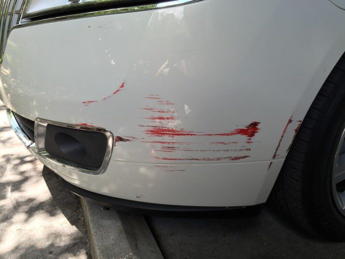

In [3]:
from PIL import Image
img = Image.open('dataset/train/image67.jpg')
#img.size
img.resize((345,259))

In [4]:
!  head dataset/train/via_region_data.json

{"test_pattern_qbist.jpg129855":{"fileref":"","size":129855,"filename":"test_pattern_qbist.jpg","base64_img_data":"","file_attributes":{},"regions":{}},"a_swan_swimming_in_geneve_lake.jpg62201":{"fileref":"","size":62201,"filename":"a_swan_swimming_in_geneve_lake.jpg","base64_img_data":"","file_attributes":{},"regions":{}},"sinus_test_pattern.jpg27894":{"fileref":"","size":27894,"filename":"sinus_test_pattern.jpg","base64_img_data":"","file_attributes":{},"regions":{}},"image67.jpg47277":{"fileref":"","size":47277,"filename":"image67.jpg","base64_img_data":"","file_attributes":{},"regions":{"0":{"shape_attributes":{"name":"polygon","all_points_x":[298,327,346,369,522,512,488,393,307,288,298],"all_points_y":[199,203,241,265,246,290,320,322,318,264,199]},"region_attributes":{"name":"damage"}},"1":{"shape_attributes":{"name":"polygon","all_points_x":[241,237,220,193,150,173,212,247,248,241],"all_points_y":[167,172,194,199,206,210,202,184,165,167]},"region_attributes":{"name":"damage"}}}},

In [5]:
import json
with open('dataset/train/via_region_data.json', 'r') as f:
  jd = json.loads(f.read())

In [7]:
#jd

In [8]:
jd['image67.jpg47277']

{'base64_img_data': '',
 'file_attributes': {},
 'filename': 'image67.jpg',
 'fileref': '',
 'regions': {'0': {'region_attributes': {'name': 'damage'},
   'shape_attributes': {'all_points_x': [298,
     327,
     346,
     369,
     522,
     512,
     488,
     393,
     307,
     288,
     298],
    'all_points_y': [199, 203, 241, 265, 246, 290, 320, 322, 318, 264, 199],
    'name': 'polygon'}},
  '1': {'region_attributes': {'name': 'damage'},
   'shape_attributes': {'all_points_x': [241,
     237,
     220,
     193,
     150,
     173,
     212,
     247,
     248,
     241],
    'all_points_y': [167, 172, 194, 199, 206, 210, 202, 184, 165, 167],
    'name': 'polygon'}}},
 'size': 47277}

In [9]:
region_pts = []
for k,region in jd['image67.jpg47277']['regions'].items():
  pts = []
  shape = region.get('shape_attributes')
  for x,y in zip(shape.get('all_points_x'),shape.get('all_points_y')):
    pts.append([x,y])
  region_pts.append(pts)

In [10]:
region_pts

[[[298, 199],
  [327, 203],
  [346, 241],
  [369, 265],
  [522, 246],
  [512, 290],
  [488, 320],
  [393, 322],
  [307, 318],
  [288, 264],
  [298, 199]],
 [[241, 167],
  [237, 172],
  [220, 194],
  [193, 199],
  [150, 206],
  [173, 210],
  [212, 202],
  [247, 184],
  [248, 165],
  [241, 167]]]

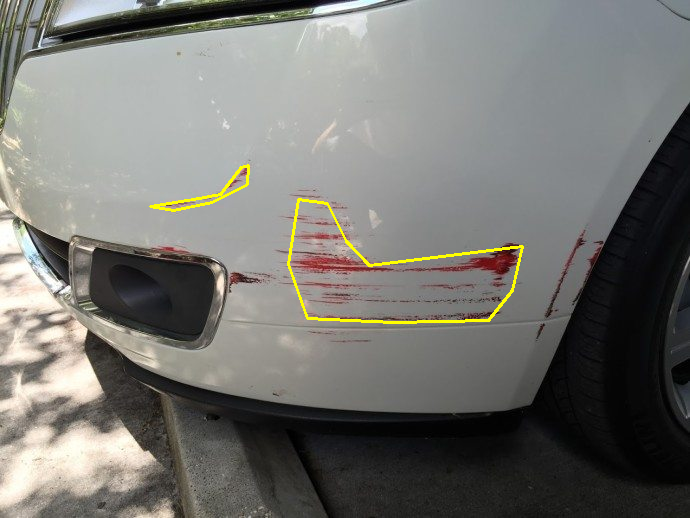

In [11]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

im = cv.imread('dataset/train/image67.jpg')
for pts in region_pts:
  pts = np.array(pts,np.int32)
  pts = pts.reshape((-1,1,2))
  cv.polylines(im,[pts],True,(0,255,255),2)
cv2_imshow(im)

## 標記工具
- https://www.robots.ox.ac.uk/~vgg/software/via/via-1.0.6.html

## 安裝 Mask-RCNN

In [12]:
%tensorflow_version 1.x 

TensorFlow 1.x selected.


In [13]:
! pip install keras==2.2.5
! pip install keras==2.2.5

     |████████████████████████████████| 337kB 4.0MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
  Using cached https://files.pythonhosted.org/packages/f8/ba/2d058dcf1b85b9c212cc58264c98a4a7dd92c989b798823cc5690d062bb2/Keras-2.2.5-py2.py3-none-any.whl
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [14]:
! git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 15.45 MiB/s, done.
Resolving deltas: 100% (560/560), done.


In [ ]:
%cd Mask_RCNN/
!pip install -r requirements.txt
!python setup.py install

In [20]:
% cd /content/
! wget https://raw.githubusercontent.com/ywchiu/fubondl/main/script/custom.py

/content
--2021-01-15 08:51:55--  https://raw.githubusercontent.com/ywchiu/fubondl/main/script/custom.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13940 (14K) [text/plain]
Saving to: ‘custom.py.1’

custom.py.1         100%[===================>]  13.61K  --.-KB/s    in 0.001s  

2021-01-15 08:51:56 (19.2 MB/s) - ‘custom.py.1’ saved [13940/13940]



In [17]:
! diff -u custom.py Mask_RCNN/samples/balloon/balloon.py > diff.log

In [ ]:
! python custom.py train --dataset=/content/dataset --weights=coco 

## 預測

In [24]:
import sys
sys.path.append('/content/Mask_RCNN')

In [31]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import custom 

MODEL_DIR = 'logs/'
custom_WEIGHTS_PATH = "/content/logs/damage20210115T0852/mask_rcnn_damage_0006.h5"  # TODO: update this path

In [26]:
config = custom.CustomConfig()
custom_DIR = "/content/dataset/"

In [27]:
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [28]:
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [29]:
dataset = custom.CustomDataset()
dataset.load_custom(custom_DIR, "val")

dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 15
Classes: ['BG', 'damage']


In [32]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)







Re-starting from epoch 6


In [35]:
import random
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)


image ID: damage.image79.jpg (2) /content/dataset/val/image79.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  335.00000  max:  827.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


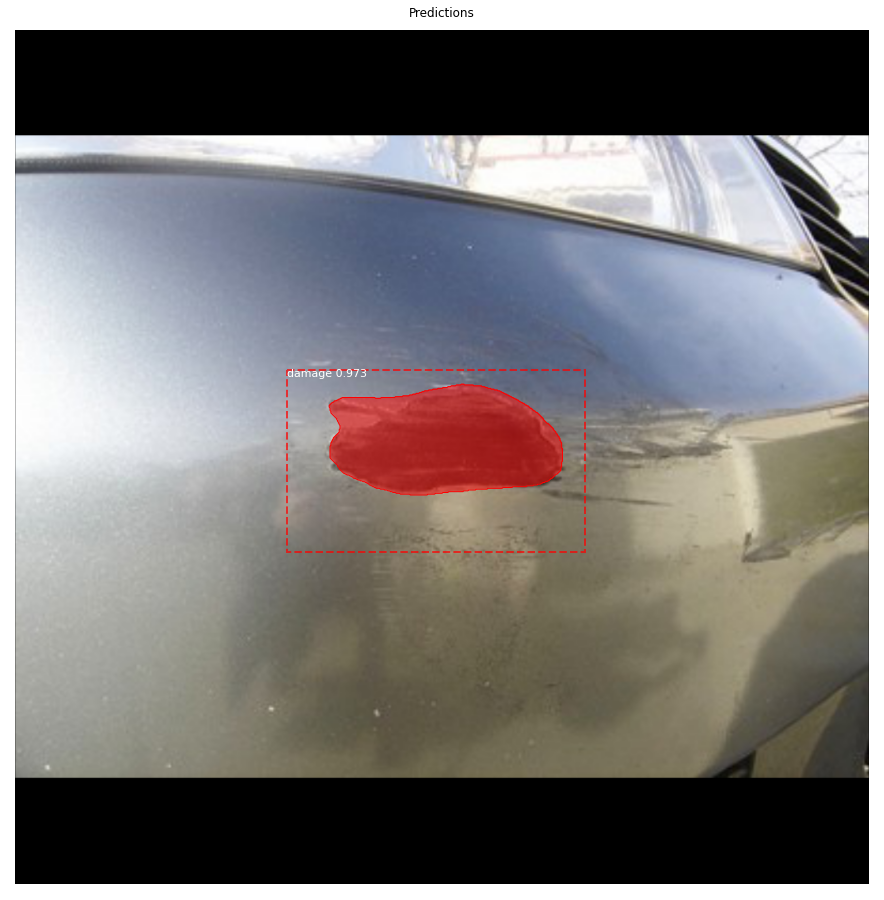

In [36]:
from matplotlib import pyplot as plt
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [ ]:
! python custom.py train --dataset=/content/dataset  --weights=last